# Automatic Threshold Detection

Generate a statistical approach that predicts the maximum idle state engine speed  e.g. a threshold that distinguishes idle from work activity based on the engine speed signal of the machine.

- Given is a dataset that provides engine speed tracked over 20000 seconds in time at 1 Hz for 5 vehicles. The engine speed has a direct correspondence to the kind of activity the machine does.
- The density function for the engine speed should show two larger distributions. One sharp peak around the idle point of the Diesel engine (~ 800 - 1000 rpm) and a wider distribution around the working point of this machine. There might be a smooth transition between both distributions.
- A threshold should be detected automatically from these distributions to distinguish between idle and working state (e.g. < 900 rpm -> idle, >= 900 rpm -> work).
- To detect a threshold Gaussian Mixtures Models or a Dirichlet process should be fitted to density function. The idle threshold should selected in a way that it covers a reasonable amount of the time spend in idling (please explain your approach).
- Outliers (0 rpm and excessive rpm values > 2500 rpm) should be dropped.


Your main objective is to define an approach
- To validate input data before pushing it for threshold detection.
- To identify the threshold.
- To validate the threshold generated.

# Deliverables
- Runable Jupyter notebook with all its dependancies and packages mentioned
- Succinctly explain all your assumptions and the reasons behind approaches
- Generate a report that best describes the outcome along with valuable metrics

In [1]:
import pandas as pd
import os
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.stats import norm
from sklearn.mixture import BayesianGaussianMixture

## Read Files

In [2]:
df = pd.read_parquet('engine_speeds.pq')
df.shape

(80000, 1)

## Data Statistics

In [3]:
df.isna().sum()

engine_speed    0
dtype: int64

In [4]:
df.reset_index().groupby('machine_id')['engine_speed'].count().to_frame()

,engine_speed
machine_id,
0,20000
1,20000
3,20000
4,20000


array([<Axes: title={'center': '0'}, ylabel='Frequency'>,
       <Axes: title={'center': '1'}, ylabel='Frequency'>,
       <Axes: title={'center': '3'}, ylabel='Frequency'>,
       <Axes: title={'center': '4'}, ylabel='Frequency'>], dtype=object)

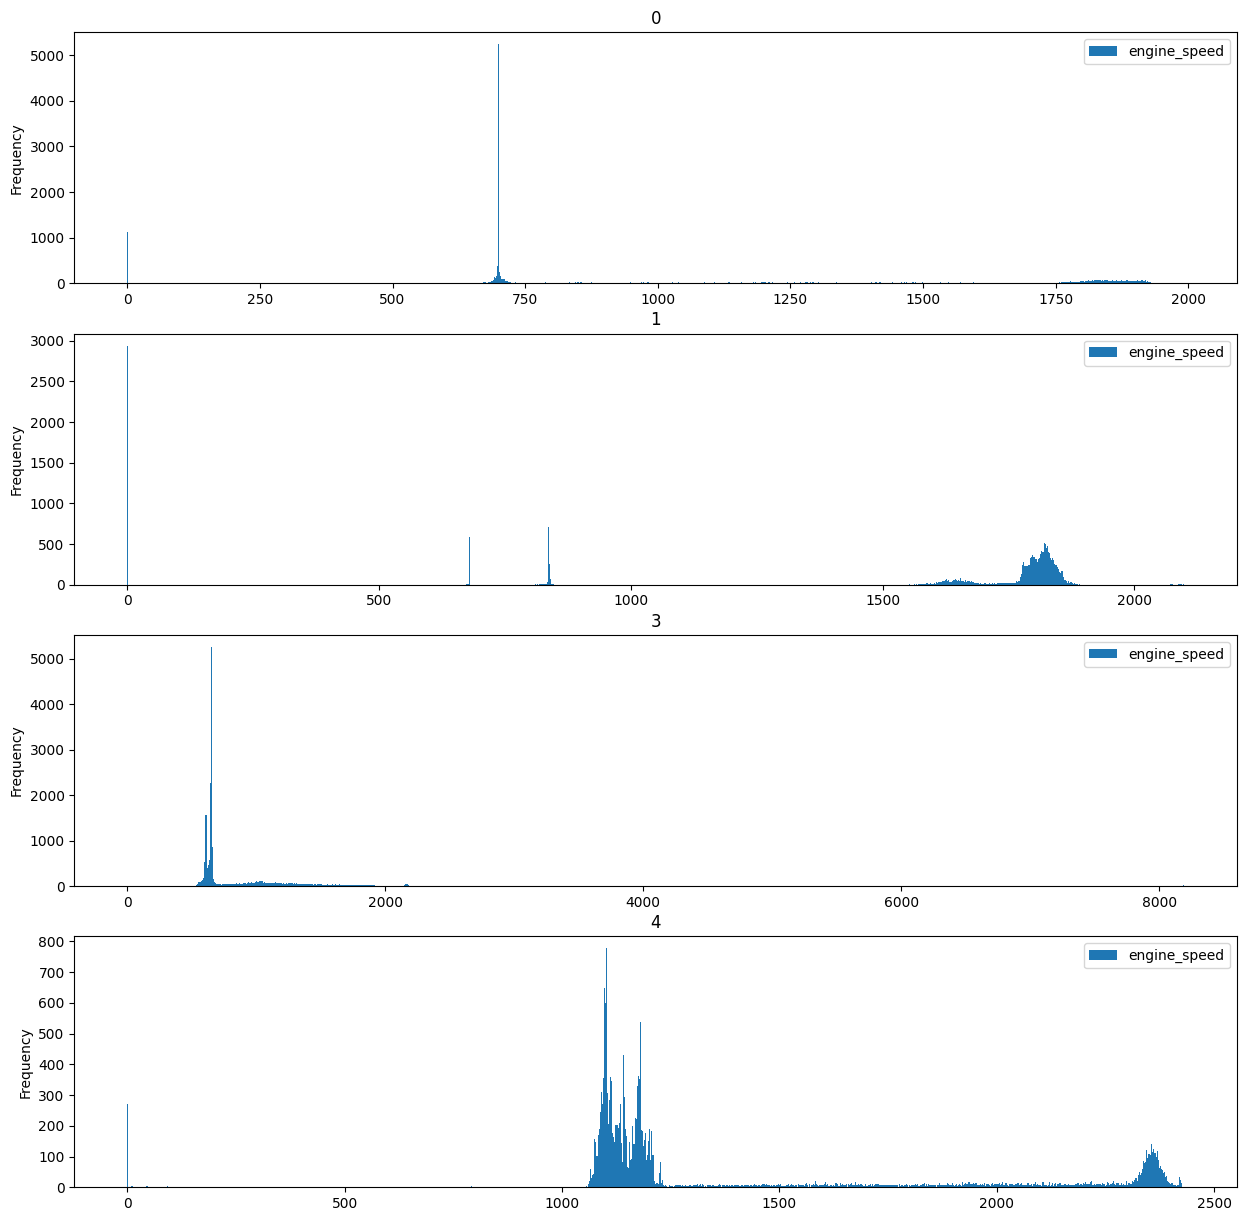

In [5]:
df.reset_index().plot.hist(column='engine_speed', by='machine_id', figsize=(15, 15), bins=1000)

## Solution

Overview of the solution

-  Validating Input Data
    - Data Cleaning
    - Visual Inspections
-  Training model and Identifying the Threshold
    -  Define Threshold
    -  BGMM
-  Result Validation
    -  Visual Verification
    -  Metrics Evaluation
-  Conclustion



### Validating Input Data

#### Cleaning

In [6]:
#Remove outliers
df = df[(df['engine_speed'] > 0) & (df['engine_speed'] <= 2500)]
df = df.reset_index()
df.head()

,machine_id,index,engine_speed
0,0,0,701.50000
1,0,1,681.53674
2,0,2,987.33124
3,0,3,1162.61250
4,0,4,1315.30630


In [7]:
# Group by machine_id for later processing
df_grouped = df.groupby('machine_id')

#### Visualization

There is actually no time componet in the dataset, just index order.  It is obvious through plotting that the indexes are causally related within each Machine subset.  Meaning it appears that the data is sorted by time.

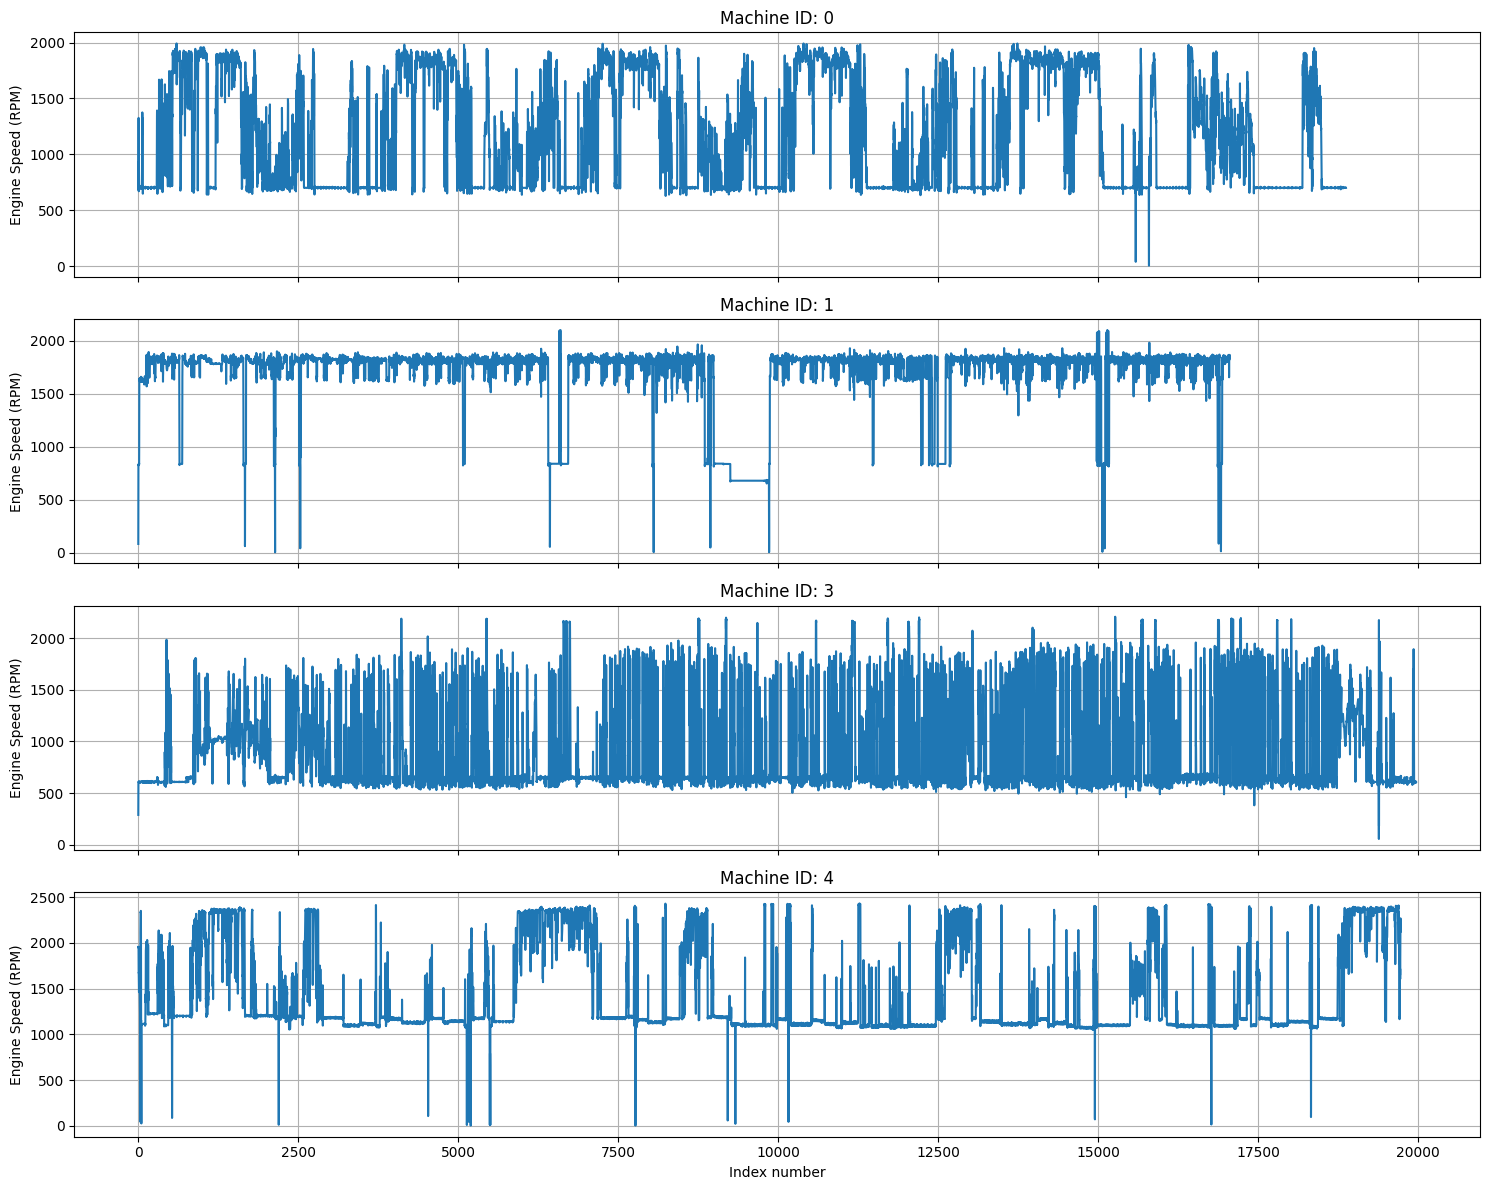

In [8]:
n_machines = df['machine_id'].nunique()
machine_ids = df['machine_id'].unique()
fig, axes = plt.subplots(n_machines, 1, figsize=(15, 3 * n_machines), sharex=True)

for ax, (name, group) in zip(axes, df_grouped):
    group = group.reset_index(drop=True)
    ax.plot(group.index, group['engine_speed'], label=f'Machine ID: {name}')
    ax.set_title(f'Machine ID: {name}')
    ax.grid(True)
    ax.set_ylabel('Engine Speed (RPM)')
axes[-1].set_xlabel('Index number')
plt.tight_layout()
plt.show()

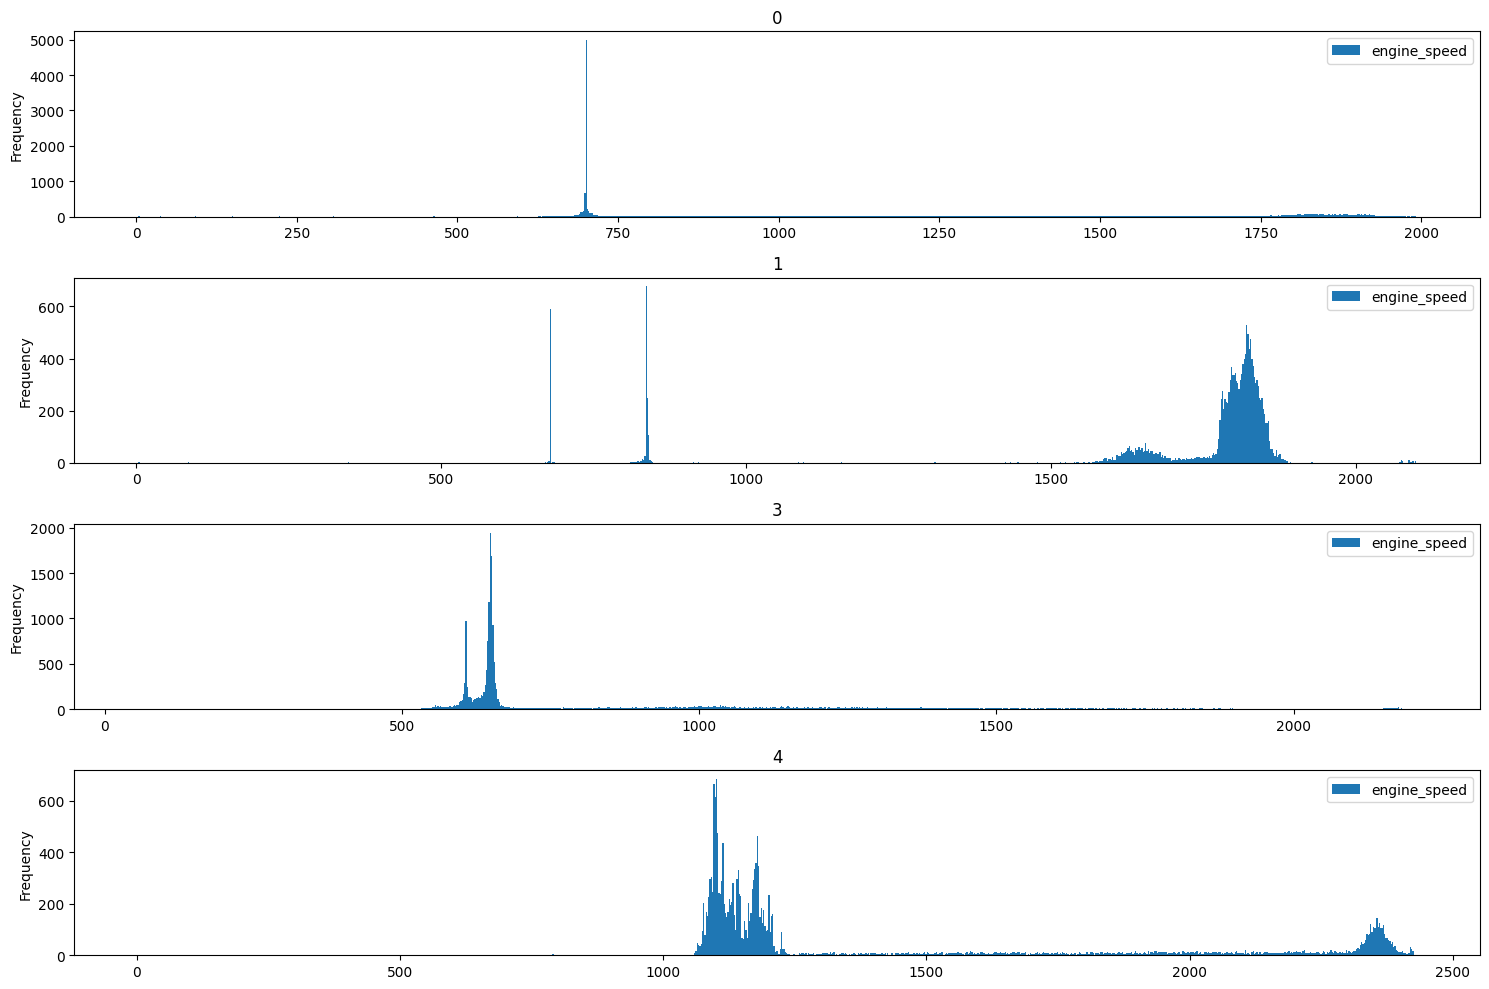

In [9]:
ax = df.reset_index().plot.hist(column='engine_speed', by='machine_id', figsize=(15, 10), bins=1000)
plt.tight_layout()
plt.show()

Large spikes in the data can sometimes obscure finer details. Taking the logarithm of the data provides a clearer perspective on its distribution, making underlying patterns more discernible.

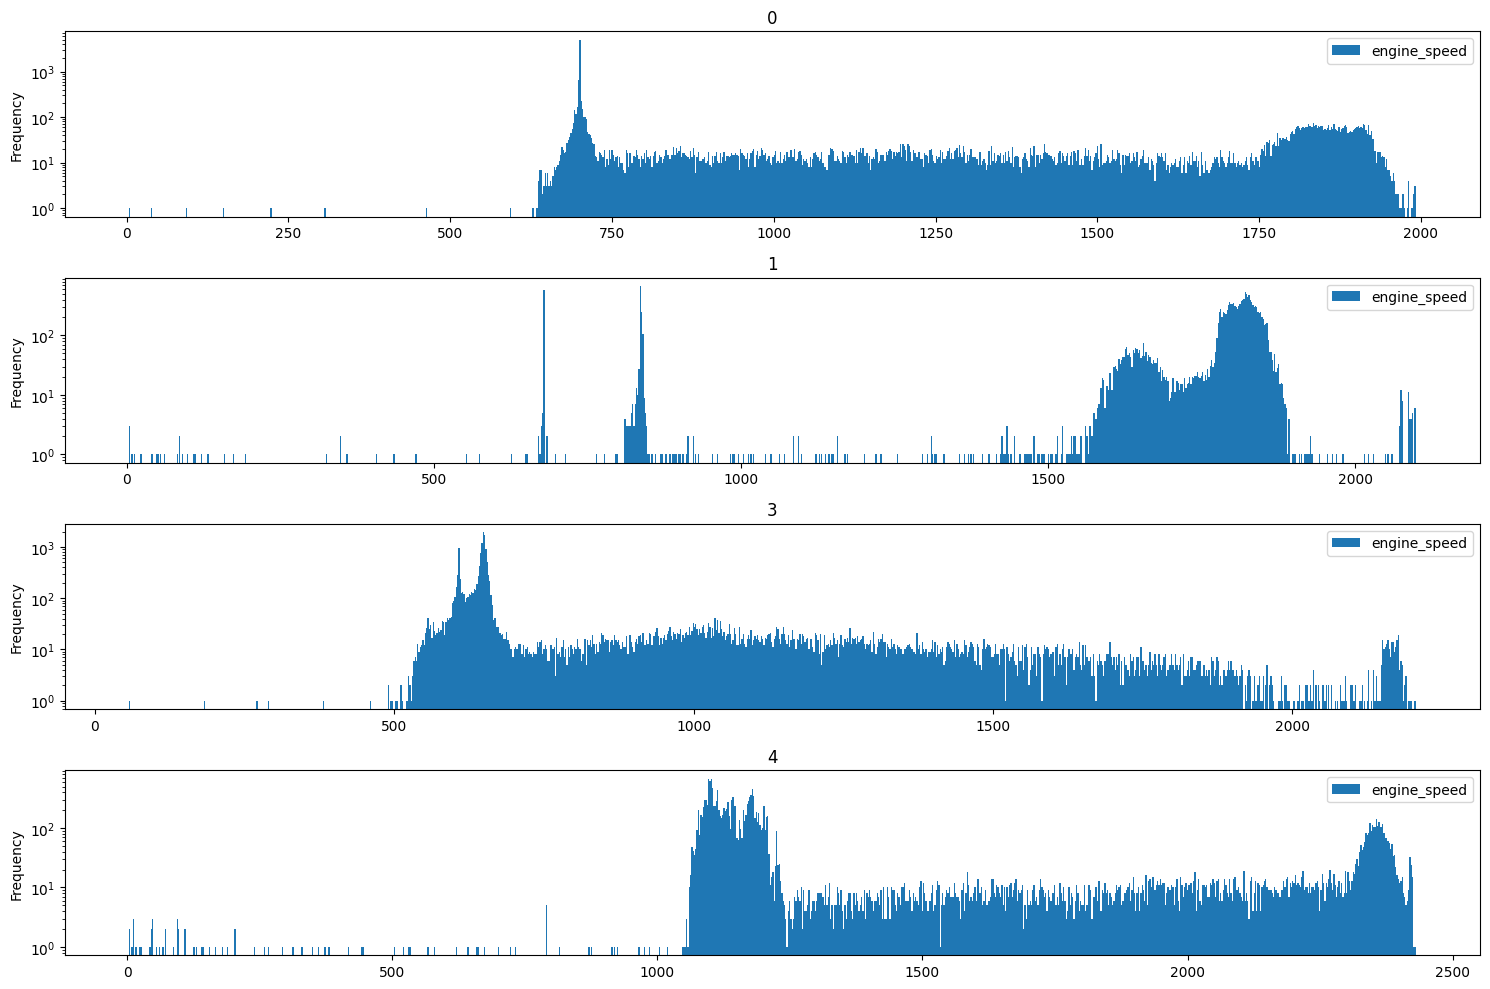

In [10]:
ax = df.reset_index().plot.hist(column='engine_speed', by='machine_id', figsize=(15, 10), bins=1000, logy=True)
plt.tight_layout()
plt.show()

### Training model and Identifying the Threshold

#### Define Threshold

Given:


*   $C_j$: the $j$-th Gaussian component. This represents the different states.  Idle index is $j=0$, and Work index is $j=1$
*   $p(x|C_j)$: Likelihood of observing $x$ given given the state $C_j$​. This is defined by the Gaussian distribution with parameters $μ_j$​ and $\sigma_j$​.
*   $w_j$​: Prior probability or weight of the $j$-th Gaussian component.  If given 80 idle, and 20 work datapoints, $w_0 = 0.8$ and $w_1 = 0.2$
*   $p(x)$: Marginal likelihood of $x$, which can be seen as a normalization factor. The marginal likelihood combines all those chances to give you one overall probability of observing that specific RPM, taking into account all possible states.


$ p(x) = \sum_j w_j \times p(x|C_j) $

The marginal likelihood Gaussian distribution of $x$ given the state $ C_j $ is  $ p(x|C_j) $:

$ p(x|C_j) = \frac{1}{\sqrt{2\pi \sigma_j}} \exp\left(-\frac{(x-\mu_j)^T}{2\sigma_j}  \right) $

The posterior probability of $x$ belonging to state $C_j$​ is given by:

$ P(C_j|x) = \frac{w_j \times p(x|C_j)}{p(x)} $



In our GMM model, we will use the **prediction threshold** for a machine $m$ as  the **intersection point of the two Gaussian distributions** specific to that machine for a given datapoint $x_i$​, where $i$ denotes the index.


$ \text{P}(C_0|x_i) = \text{P}(C_1|x_i) $

Thus, a datapoint will be classified as "idle" when:

$ \text{P}(C_0|x_i) >= \text{P}(C_1|x_i)$

and "work" when:

$ \text{P}(C_0|x_i)  < \text{P}(C_1|x_i)$

The same proababilities will be classified as "idle".

#### BGMM Modeling

For our analysis, it's essential to develop a **distinct Gaussian Mixture Model (GMM) for each asset (Machine ID)**. This is premised on the understanding that **individual assets exhibit unique Gaussian distributions** for both idle and working states.


While a conventional GMM is a viable approach in this context, we're opting for a **Bayesian Gaussian Mixture Model** (BGMM). The standard GMM leverages the Expectation Maximization (EM) algorithm, whereas the BGMM employs Variational Inference (VI). 
Variational inference is an extension of Expectation-Maximization which includes includes a regularization by integrating information from prior distributions.  

Our primary goal is to predict two distinct states: 'Idle' and 'Working.' therefore there's **no need to determine the underlying number of data components**. 

In [11]:
# Create a dictionary to store the GMM models and idle thresholds per machine
gmm_models = {}
idle_threshs = {}
silhouettes = {}
predictions= {}
prediction_prob = {}
touch_points = {}
component_labels = {0: 'Idle Distribution', 1: 'Work Distribution'}

In [12]:
def fit_gmm(data):
    gmm = BayesianGaussianMixture(n_components=2)
    gmm.fit(data.values)
   
    # Swap to ensure lower indexed item is "Idle"
    if gmm.means_[0] > gmm.means_[1]:
        gmm.means_ = gmm.means_[::-1]
        gmm.covariances_ = gmm.covariances_[::-1]
        gmm.weights_ = gmm.weights_[::-1]
        gmm.precisions_ = gmm.precisions_[::-1]
        gmm.precisions_cholesky_ = gmm.precisions_cholesky_[::-1]
        
    labels = gmm.predict(data.values)
    probs = gmm.predict_proba(data.values)

    # Find the upperbound predition for the Idle state
    x_range = np.arange(0,np.max(data.values)).reshape(-1, 1)
    posterior_probs = gmm.predict_proba(x_range)
    # Find where they meet
    diff = np.abs(posterior_probs[:, 0] - posterior_probs[:, 1])
    sorted_indices = np.argsort(diff)

    # Sometimes a minimum is to the left of the idle mean,  this fixes that scenario
    if x_range[sorted_indices[0]][0] < gmm.means_[0]:
        touch_point_idx = sorted_indices[1]
    else:
        touch_point_idx = sorted_indices[0]
    touch_point = x_range[touch_point_idx][0]
    
    return gmm, labels, probs, touch_point

Iterate over each machine's data and fit GMM

In [13]:
for machine_id, machine_data in df_grouped:
    gmm, pred, pred_prob, touch_point = fit_gmm(machine_data[['engine_speed']])
    gmm_models[machine_id] = gmm
    touch_points[machine_id] = touch_point
    predictions[machine_id] = pred
    prediction_prob[machine_id] = pred_prob

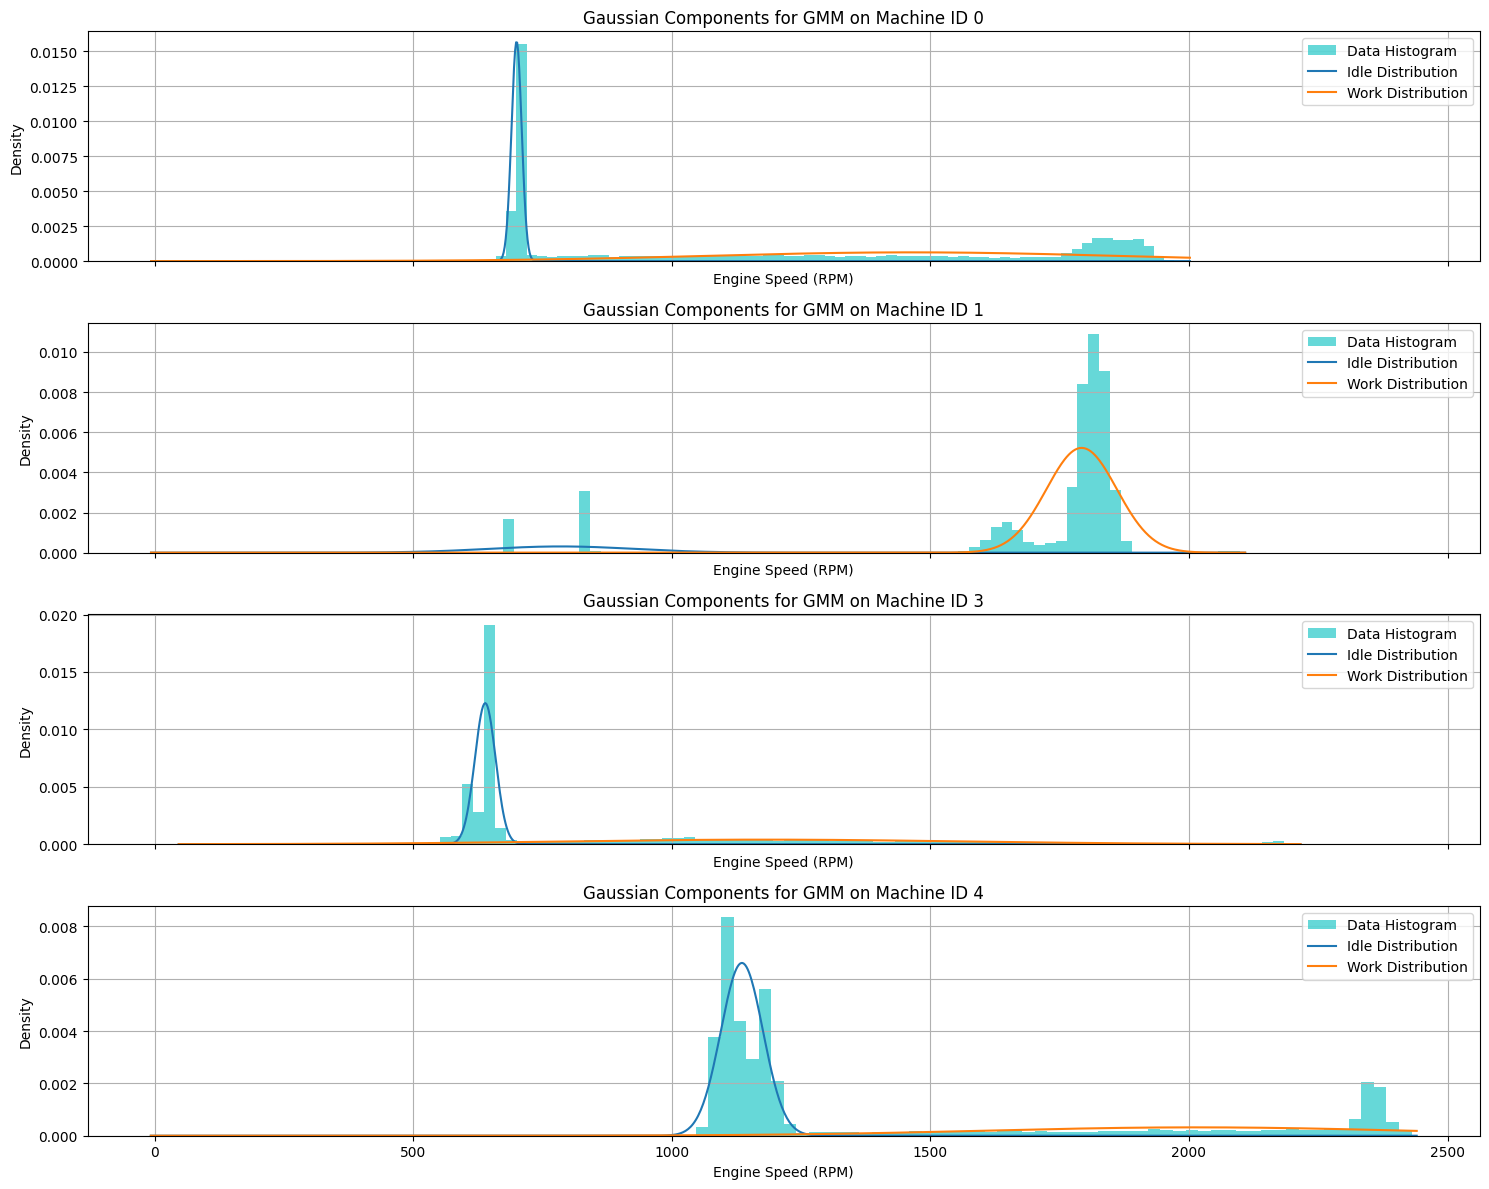

In [14]:
fig, axes = plt.subplots(n_machines, 1, figsize=(15, 3 * n_machines), sharex=True)

for ax, (machine_id, group) in zip(axes, df_grouped):
    x = np.linspace(group['engine_speed'].min() - 10, group['engine_speed'].max() + 10, 1000)
    
    # Plot the original data
    ax.hist(group['engine_speed'], bins=100, density=True, alpha=0.6, color='c', label="Data Histogram")

    gmm = gmm_models[machine_id]
    
    # Plot each Gaussian component
    for i in range(gmm.n_components):
        mean = gmm.means_[i][0]
        covariance = gmm.covariances_[i][0]
        weight = gmm.weights_[i]
        ax.plot(x, weight * norm.pdf(x, mean, np.sqrt(covariance)),
                label=component_labels.get(i, f'Component {i + 1}'))

    ax.legend()
    ax.grid(True)
    ax.set_title(f'Gaussian Components for GMM on Machine ID {machine_id}')
    ax.set_ylabel('Density')
    ax.set_xlabel('Engine Speed (RPM)')

plt.tight_layout()
plt.show()


Below is the maximum idle state engine speed for each machine.

In [15]:
for machine_id, touch_point in touch_points.items():
    print(f"Machine ID: {machine_id}, Idle Upper limit: {round(touch_point)}")

Machine ID: 0, Idle Upper limit: 734
Machine ID: 1, Idle Upper limit: 1478
Machine ID: 3, Idle Upper limit: 691
Machine ID: 4, Idle Upper limit: 1261


### Result Validation

#### Visual Verification

##### Frequency Domain

Given certain covariance values, one Gaussian distribution may exhibit such **rapid tail decay** that it appears, in essence, to be enveloped by the second distribution. 

This phenomenon is particularly evident in the data pertaining to **Machine ID: 0 and 3**

In [16]:
weights = gmm_models[0].weights_
means = gmm_models[0].means_.flatten()
covariances = gmm_models[0].covariances_.flatten()
print('Idle covariances  %.3f' %covariances[0] )
print('Work covariances  %.3f' %covariances[1])

Idle covariances  96.944
Work covariances  152416.891


In [17]:
weights = gmm_models[3].weights_
means = gmm_models[3].means_.flatten()
covariances = gmm_models[3].covariances_.flatten()
print('Idle covariances  %.3f' %covariances[0] )
print('Work covariances  %.3f' %covariances[1])

Idle covariances  402.753
Work covariances  147829.823


The covariance of the prior is substantially greater by several orders of magnitude. A closer examination of the Idle Gaussian distribution reveals this. Specifically, for Machine 0, a prediction of 'Idle' is assigned if the RPM lies within the narrow range of approximately 665 to 730.

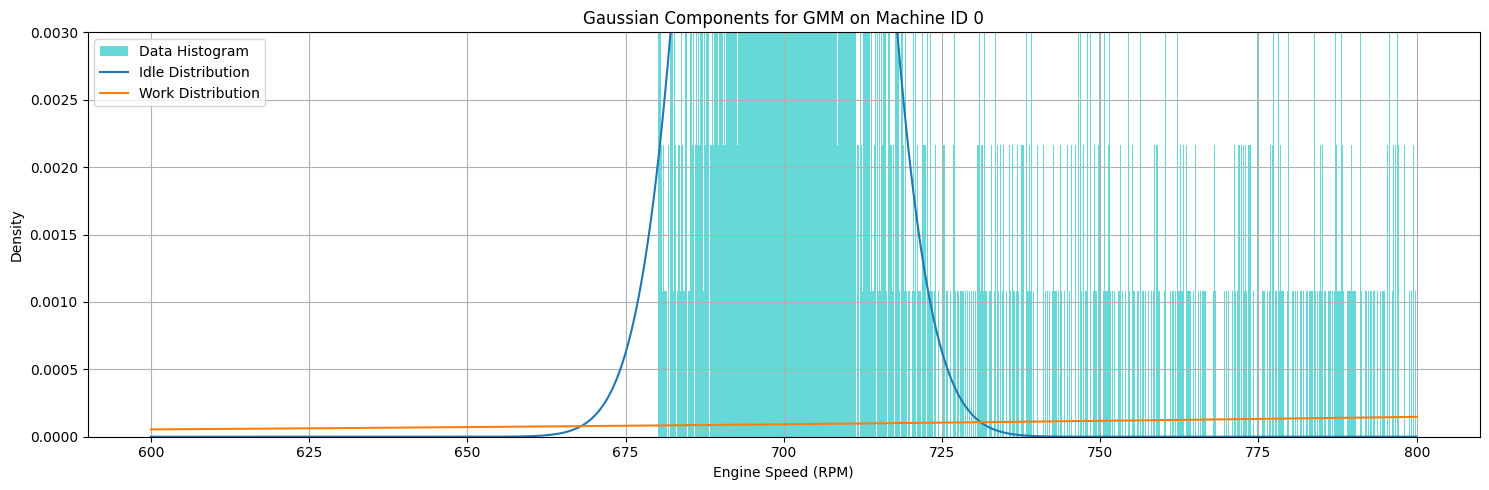

In [18]:
tmp_m_id = 0
fig, ax = plt.subplots(figsize=(15, 5))
x = np.linspace(600, 800, 1000)

# Plot the original data within the range 600-800
machine0 = df_grouped.get_group(0)['engine_speed']
machine0 = machine0[(machine0 >= 680) & (machine0 <= 800)]
ax.hist(machine0, bins=1000, density=True, alpha=0.6, color='c', label="Data Histogram")

# Plot each Gaussian component
for i in range(gmm_models[0].n_components):
    mean = gmm_models[tmp_m_id].means_[i][0]
    covariance = gmm_models[tmp_m_id].covariances_[i][0]
    weight = gmm_models[tmp_m_id].weights_[i]
    ax.plot(x, weight*norm.pdf(x, mean, np.sqrt(covariance)), label=component_labels.get(i, f'Component {i+1}'))

ax.legend()
ax.grid(True)
ax.set_title(f'Gaussian Components for GMM on Machine ID {tmp_m_id}')
ax.set_ylabel('Density')
ax.set_xlabel('Engine Speed (RPM)')

plt.ylim(0, 0.003)
plt.tight_layout()
plt.show()


##### Time Domain

In the following section, we depict the predictions for each machine. Observing Machine ID: 0, one can discern that certain data points, even with RPMs lower than the 'Idle' state, are classified as 'Work'. This phenomenon comes from the rapid decay of the 'Idle' Gaussian distribution's left tail, which becomes swiftly overshadowed by the 'Work' distribution.

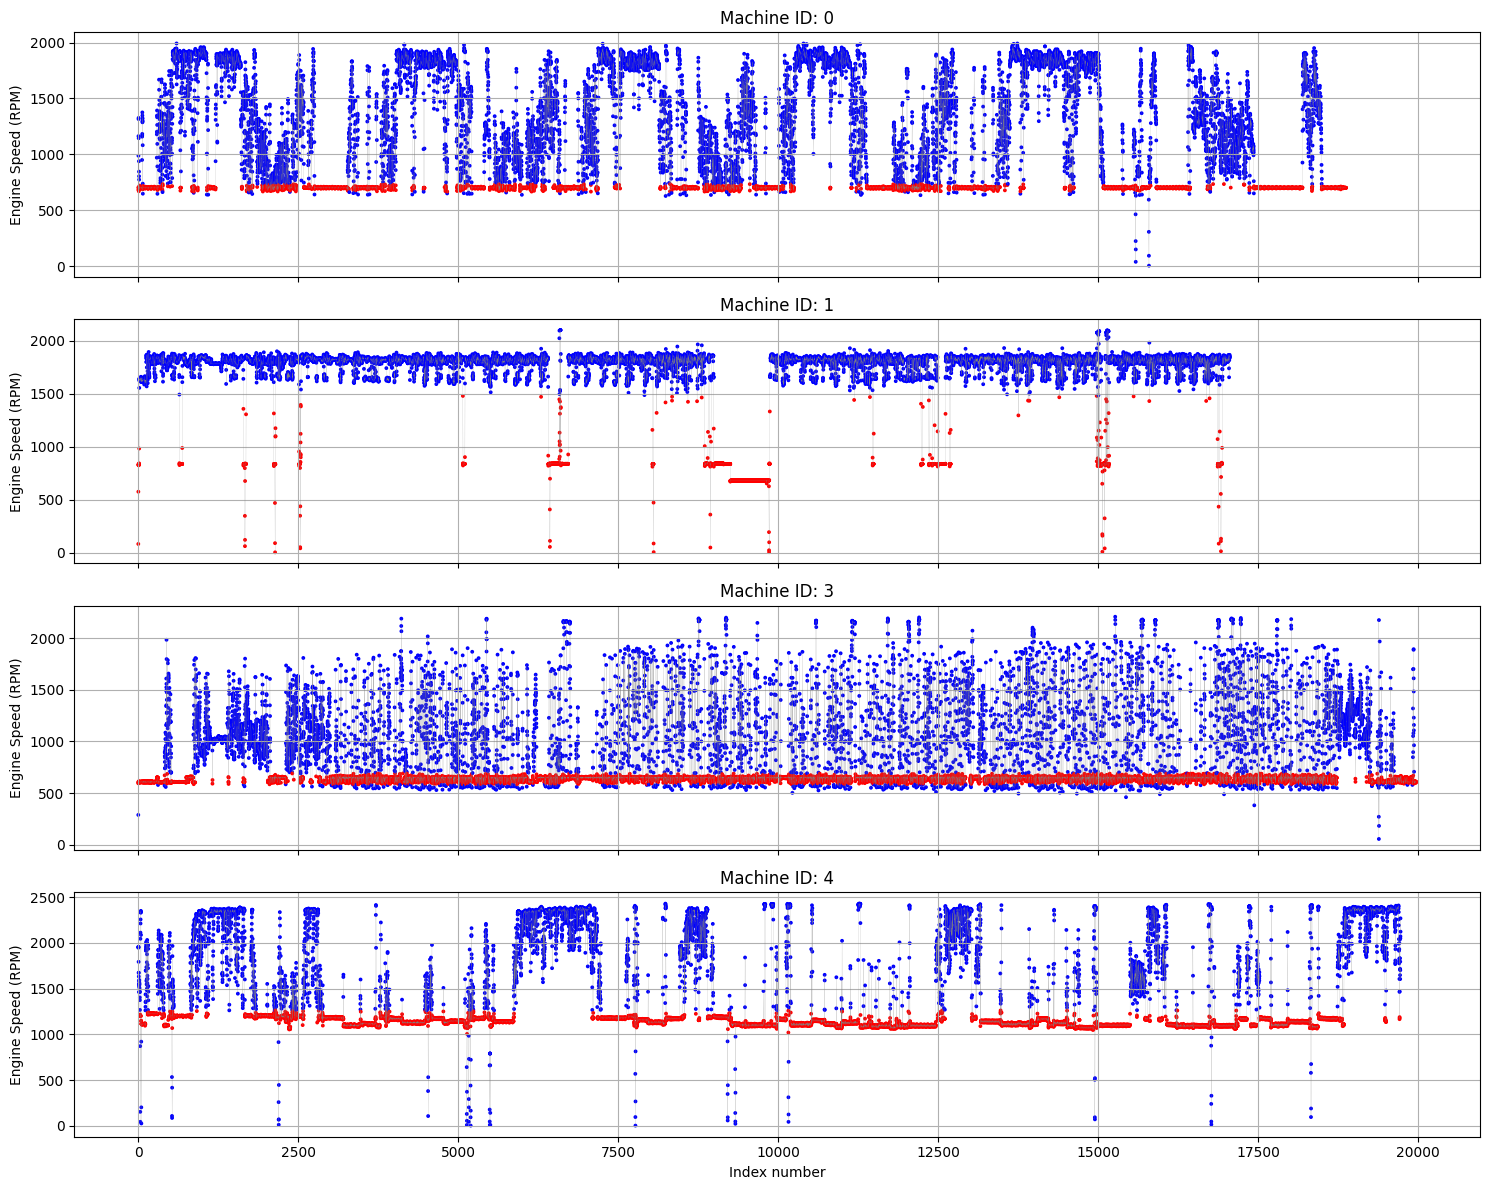

In [19]:
fig, axes = plt.subplots(n_machines, 1, figsize=(15, 3 * n_machines), sharex=True)

for ax, (name, group) in zip(axes, df_grouped):
    group = group.reset_index(drop=True)
    predicted_states = predictions[name]
    # Determine the colors based on the predicted state
    colors = ['r' if state == 0 else 'b' for state in predicted_states]
    ax.scatter(group.index, group['engine_speed'], color=colors, s=3)
    ax.plot(group.index, group['engine_speed'], color='gray', lw=0.1)  # Overlay with a continuous line for clarity
    ax.set_title(f'Machine ID: {name}')
    ax.set_ylabel('Engine Speed (RPM)')
    ax.grid(True)
axes[-1].set_xlabel('Index number')
plt.tight_layout()
plt.show()

#### High Confidence Prediction

Additionally if you don't want the prediction to predict for **unsure datapoints** we can incorperate a prediction threshold.  Experimentally a value of 95% looks usefull.  In the case of a poor prediction we would just assume the same state as the previously known prediction over 95%.

**Black points are all predictions over 95%**, while the **red points are less then 95% confidence**.

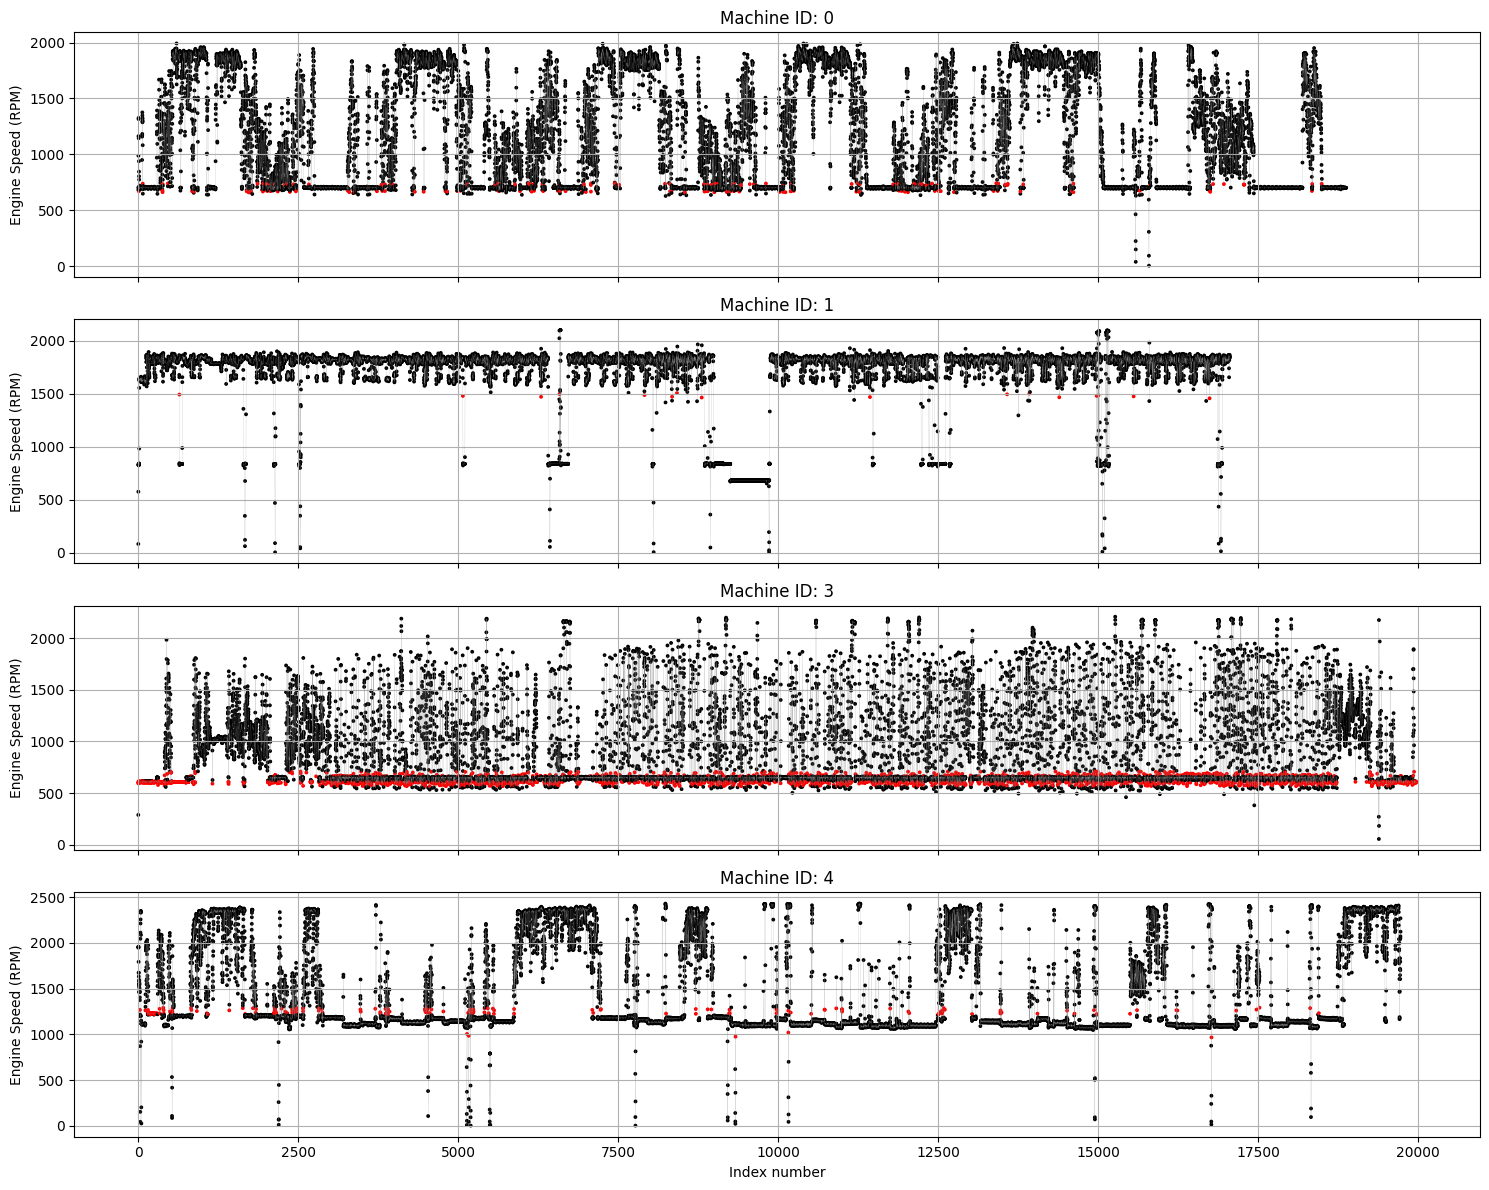

In [20]:
fig, axes = plt.subplots(n_machines, 1, figsize=(15, 3 * n_machines), sharex=True)

for ax, (name, group) in zip(axes, df_grouped):
    group = group.reset_index(drop=True)

    # Predict the posterior probability of each sample belonging to each of the components
    predicted_states = predictions[name]

    # Get maximum prediction probability for each point
    max_probabilities = prediction_prob[name].max(axis=1)

    # Determine the colors based on the predicted state and the probability
    colors = []
    for state, prob in zip(predicted_states, max_probabilities):
        # print(prob)
        if prob <= 0.94:
            colors.append('r')
        elif state == 0:
            colors.append('k')
        else:
            colors.append('k')

    ax.scatter(group.index, group['engine_speed'], color=colors, s=3)
    ax.plot(group.index, group['engine_speed'], color='gray', lw=0.1)  # Overlay with a continuous line for clarity
    ax.set_title(f'Machine ID: {name}')
    ax.set_ylabel('Engine Speed (RPM)')
    ax.grid(True)
axes[-1].set_xlabel('Index number')
plt.tight_layout()
plt.show()

#### Metrics Evaluation

##### Solhouette score

The silhouette score is a measure used to evaluate the **validity of a clustering algorithm's results**. It measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The value of the silhouette score ranges between -1 and 1. A high value indicates that the object is well matched to its cluster and poorly matched to neighboring clusters.

Mathematically, for each sample:

$a$ is the average intra-cluster distance

$b$ is the average nearest-cluster distance

The silhouette score $s$ for a single sample is given by:
$s=\frac{b−a}{max⁡(a,b)}$


It provides an objective metric to evaluate and compare the quality of clusters.

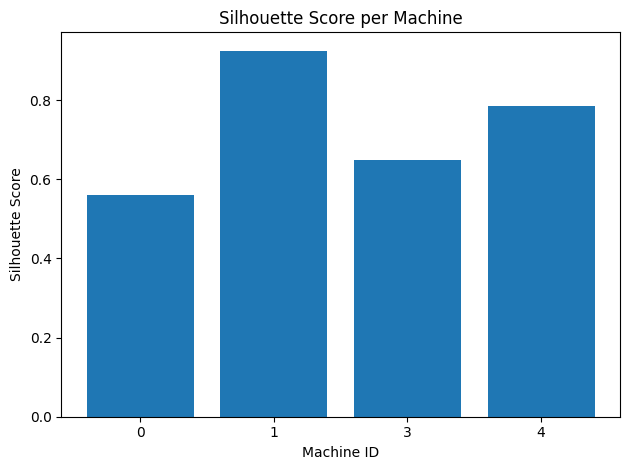

In [21]:
silhouettes = {}
# Plotting

# Iterate over each machine's data and fit GMM
for machine_id, machine_data in df_grouped:
    predicted_states = predictions[machine_id]
    silhouettes[machine_id] = silhouette_score(machine_data[['engine_speed']],
                                               predicted_states)
silhouette_scores = list(silhouettes.values())
plt.bar(range(len(machine_ids)), silhouette_scores, tick_label=machine_ids)
# plt.bar(machine_ids, silhouettes)
plt.xlabel('Machine ID')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score per Machine')
plt.tight_layout()
plt.show()

Machines ID 0 and 3 have the lowest scores, indicating less distinct separations by the BGMM compared to Machines ID 1 and 4. Analyzing the raw data, we find that Machines 0 and 3 lack a clear upper boundary for the 'Working' state. This leads the model to adjust the covariance for the 'Working' state, resulting in a closer overlap between 'Idle' and 'Work' distributions."

##### Occurance of high predictions

The below graph gives you a sence of how often the model is "confident" in it's predictions for each machine. The vast majority of predictions have a high confidence. Machine ID: 0 is hidden due to overlap.

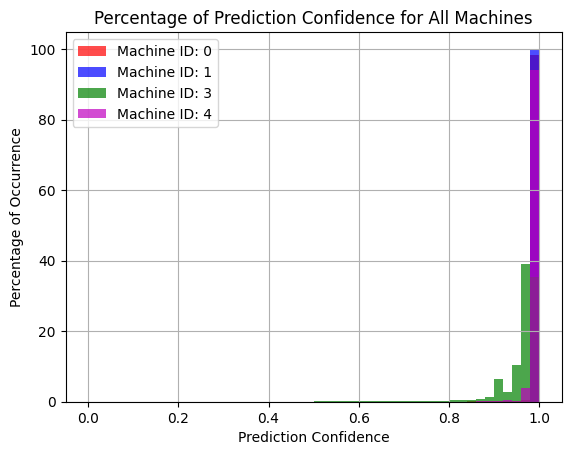

In [22]:
bins = np.linspace(0, 1, 51)  # 50 bins between 0 and 1
colors = ['r','b','g','m']
for color, (name, group) in zip(colors, df_grouped):
    pred_probs = prediction_prob[name]
    max_confidences = np.max(pred_probs, axis=1)

    # Calculate histogram
    hist, bin_edges = np.histogram(max_confidences, bins=bins)

    # Convert histogram values to percentages
    hist_percentage = hist / np.sum(hist) * 100

    # Plot bar chart for each bin
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(bin_centers, hist_percentage, width=(bins[1] - bins[0]), alpha=0.7, color=color, label=f'Machine ID: {name}')

plt.xlabel('Prediction Confidence')
plt.ylabel('Percentage of Occurrence')
plt.title('Percentage of Prediction Confidence for All Machines')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [23]:
total_predictions = 0
high_confidence_predictions = 0

for machine_id, probs in prediction_prob.items():
    max_confidences = np.max(probs, axis=1)
    high_confidence_predictions += np.sum(max_confidences > 0.95)
    total_predictions += len(max_confidences)

percentage_high_confidence = (high_confidence_predictions / total_predictions) * 100

print(f"The percentage of predictions with >95% confidence across all machines is: {percentage_high_confidence:.2f}%")

The percentage of predictions with >95% confidence across all machines is: 94.53%


### Conclusion

Above we
1.   Generated a GMM with 2 distributions per Machine ID
2.   Used the defined threshold to visually verify the results 
3.   Propose additonal threshold trigger of 95% confidence
3.   Computed metrics which evaulates the quality of the Gaussian Distribution
clusters, and the thresholds prediction quality.


The existing models provide a solid foundation for predicting whether a machine is idling or operational. They accurately capture significant durations of the idle state. However, there are instances where operational periods are seemingly  misclassified as idle and vice versa. To refine this, predictions can be focused on datapoints with high confidence scores.

Experimental findings indicate that the GMM yields a more narrower covariance which doesn't visually fit the data, particularly for Machine ID: 0. The BGMM seems to produce results which more closely resemble the actual distribution.

Across all machines, the models predict with a confidence of 95%, approximately 97.7% of the time. This establishes a robust baseline for implementation.

With the inclusion of additional features, particularly specific motor details or use-case information, our predictive capabilities could be significantly enhanced. Such information would also enable the merging of datasets with similar characteristics for a more comprehensive analysis.

An alternative prediction instead of using $ \text{P}(C_0|x_i) >= \text{P}(C_1|x_i)$ and $ \text{P}(C_0|x_i)  < \text{P}(C_1|x_i)$, we can use maximum idle state engine speed.  In this case everything below the calculated maximum idle speed would be considered as Idle.  We would use our previously calculated "touch_points" for this. 